<a href="https://colab.research.google.com/github/peruvianox/WEAV-AI/blob/main/WEAV_Detailed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive & Import Libraries

In [1]:
pip install pygifsicle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pygifsicle: filename=pygifsicle-1.0.7-py3-none-any.whl size=4110 sha256=c9ba6f46eb46a29955d1b5012a14acdb6ce0a837de6c2cdd342c750f3f2af5e7
  Stored in directory: /root/.cache/pip/wheels/ac/79/bb/9b5e92cd84f1b56e1eb7d1265fa0f4d5a13f3e4debb4c0b7f6
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5651 sha256=032c96590f3222033793abccfdb404d0d2fc9ec464f74a730ab4b2fe29aa24a0
  Stored in directory: /root/.cache/pip/wheels/7c/a1/b1/9662c79502c353ff7e71c36f84846acd623cbcbe3f7255f5d5
Successfully built pygifsicle support_developer


In [2]:
pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=420e9f7cff68b8fa5c2bd19b0df8eb3e871bdc49d09bd38d54cd9602b5ab6701
  Stored in directory: /root/.cache/pip/wheels/04/bb/0d/2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built littleutils


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import os
import re
import joblib
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime
from scipy import signal
from scipy import interpolate
from scipy.signal import find_peaks, resample
from google.colab import output
import seaborn as sb
import time 
import imageio
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from itertools import chain
from pygifsicle import optimize
DataFolder = '/content/drive/MyDrive/WEAV/Data'
os.chdir(DataFolder)
subjects = [x for x in os.listdir(DataFolder)]
subjects.remove('.ipynb_checkpoints')
subjects.remove('Pilot')

# Extract & Transform Data

In [51]:
# Define Active Trial Analysis Function
def TrlMetAnalysis(TrlStr, t, VO2_kg, VO2, VCO2, Mkr):
    today = dt.datetime.today()
    
    # add start and end times
    StartStr = 'Start_' + TrlStr
    EndStr = 'End_' + TrlStr
        
    # pull start and end times of trial
    StartInd = Mkr.index(StartStr)
    EndInd = Mkr.index(EndStr)
    
    # define VO2 during trial
    TrialVO2_kg = VO2_kg[StartInd:EndInd]
    TrialVO2 = VO2[StartInd:EndInd]
    TrialVCO2 = VCO2[StartInd:EndInd]
    TrialW = (np.multiply(np.divide(TrialVO2, 1000), 16.58) + 
              np.multiply(np.divide(TrialVCO2, 1000), 4.51)) * 1000 / 60 

    # create start and end times as datetimes
    StartTime = dt.datetime.combine(today, t[StartInd])
    
    # convert to seconds
    TrlSec = []
    for i in t[StartInd:EndInd]:
        TrlTime = dt.datetime.combine(today, i)
        ts = TrlTime - StartTime
        TrlSec.append(ts.total_seconds())
    
    # find final 2 min of trial
    Final2Min = [x for x in TrlSec if x >= 180]
    Final2MinInd = TrlSec.index(Final2Min[0])
    
    # average VO2 over final 2 min 
    TrialWAvg = np.mean(TrialW[Final2MinInd:EndInd])

    # filter metabolic signal to continuous measure
    f = interpolate.interp1d(TrlSec, TrialW)
    xnew = np.arange(0,max(TrlSec))
    FiltW = f(xnew)

    # trim to final 2 minutes
    FiltW = FiltW[180:300]
    xnew = xnew[180:300]

    VO2Data = {
        'Trial Name' : TrlStr,
        'Time Values' : TrlSec,
        'W Avg' : TrialWAvg,
        'All W Data' : TrialW,
        'Filt W Data' : FiltW, 
        'Filt Time' : xnew
        }
    
    return VO2Data

In [52]:
ReProcess = 1
if ReProcess == 1:
  Subj = {}
  nbins = 3
  Obj = pd.DataFrame(columns = ['Subj','Trial','MetCost'])
  c = ['Subj','Cond','Bin', 'MetCost'] # make column names for dataFrame
  df = pd.DataFrame(columns=c)

  # setup full model
  trcCols = []
  for i in range(int(14*3*120/nbins*50)):
    trcCols.append('TRC'+str(i))
  trc_full = pd.DataFrame(columns=trcCols)

  # get column names for Full condition
  Keypoints = ['Neck.X', 'Neck.Y', 'Neck.Z', 'RShoulder.X', 'RShoulder.Y', 'RShoulder.Z', 
               'RElbow.X', 'RElbow.Y', 'RElbow.Z', 'RWrist.X', 'RWrist.Y', 'RWrist.Z', 
               'LShoulder.X', 'LShoulder.Y', 'LShoulder.Z', 'LElbow.X', 'LElbow.Y', 'LElbow.Z', 
               'LWrist.X', 'LWrist.Y', 'LWrist.Z', 'midHip.X', 'midHip.Y', 'midHip.Z', 
               'RHip.X', 'RHip.Y', 'RHip.Z', 'RKnee.X', 'RKnee.Y', 'RKnee.Z', 
               'RAnkle.X', 'RAnkle.Y', 'RAnkle.Z', 'LHip.X', 'LHip.Y', 'LHip.Z', 
               'LKnee.X', 'LKnee.Y', 'LKnee.Z', 'LAnkle.X', 'LAnkle.Y', 'LAnkle.Z', 
               'LBigToe.X','LBigToe.Y', 'LBigToe.Z', 'LSmallToe.X', 'LSmallToe.Y', 'LSmallToe.Z',
               'LHeel.X', 'LHeel.Y', 'LHeel.Z', 'RBigToe.X', 'RBigToe.Y', 'RBigToe.Z',
               'RSmallToe.X', 'RSmallToe.Y', 'RSmallToe.Z', 'RHeel.X', 'RHeel.Y', 'RHeel.Z']
  TrimKeypoints = ['RShoulder.X', 'RShoulder.Y', 'RShoulder.Z',
       'RElbow.X', 'RElbow.Y', 'RElbow.Z', 'RWrist.X', 'RWrist.Y', 'RWrist.Z',
       'LShoulder.X', 'LShoulder.Y', 'LShoulder.Z', 'LElbow.X', 'LElbow.Y', 'LElbow.Z', 
       'LWrist.X', 'LWrist.Y', 'LWrist.Z', 'RHip.X', 'RHip.Y', 'RHip.Z', 
       'RKnee.X', 'RKnee.Y', 'RKnee.Z', 'RAnkle.X', 'RAnkle.Y', 'RAnkle.Z', 
       'LHip.X', 'LHip.Y', 'LHip.Z', 'LKnee.X', 'LKnee.Y', 'LKnee.Z', 
       'LAnkle.X', 'LAnkle.Y', 'LAnkle.Z', 'RToe.X', 'RToe.Y', 'RToe.Z', 
       'LToe.X', 'LToe.Y', 'LToe.Z']

  Meta = ['Subj','Cond','Bin', 'MetCost']
  new_cols_1 = []
  new_cols_2 = []
  for item in TrimKeypoints:
    for x in range(100):
      new_cols_1.append(item + str(x))
      new_cols_2.append(item + str(x) + '_std')

  full_columns = Meta + new_cols_1 + new_cols_2
  full = pd.DataFrame(columns = full_columns)

  for f in subjects:
    if re.search('.mat|.csv|.ipy|.gif', f):
      continue
    if f not in Subj:
      Subj[f] = {}
    print('Processing Subject: ' + f)
    SubjFolder = DataFolder + '/' + f
    os.chdir(SubjFolder)

    # get REE metabolic data
    reeFile = [x for x in os.listdir(SubjFolder) if 'REE' in x]
    # get body mass from ree file
    Subj[f]['Mass'] = float(pd.read_excel(reeFile[0], usecols='B', skiprows=[0,1,2,3,4], nrows=1).to_numpy().squeeze())
    RMR = pd.read_excel(reeFile[0])
    
    # pull VO2 and time data
    VO2_kg = RMR.loc[2:len(RMR),'VO2/Kg']
    VO2 = RMR.loc[2:len(RMR),'VO2']
    VCO2 = RMR.loc[2:len(RMR),'VCO2']
    t = RMR.loc[2:len(RMR),'t'].values
    W = (VO2 /1000 * 16.5 + VCO2 /1000 * 4.51) * 1000 / 60 

    # find rows after 3 min
    T = []
    c = 0
    for i in t:
      c = c + 1
      if i is np.nan:
        continue
      if i.minute >=3:
        T.append(c)  
            
    # calculate average REE
    AvgW = np.mean(W[T])     
    Subj[f]['RMR W Avg'] = AvgW 
    # normalize to body mass
    avgRMR = round(AvgW / Subj[f]['Mass'],3)
    print(f + ' Average RMR = '+ str(avgRMR) + '  mL/kg/min')

    # get met data trials
    metFile = [x for x in os.listdir(SubjFolder) if 'CPET' in x]
    metDF = pd.read_excel(metFile[0])
    
    # pull VO2 and time data
    VO2_kg = metDF.loc[2:len(metDF),'VO2/Kg']
    VO2 = metDF.loc[2:len(metDF),'VO2']
    VCO2 = metDF.loc[2:len(metDF),'VCO2']
    t = metDF.loc[2:len(metDF),'t'].values.tolist()
    Mkr = metDF.loc[2:len(metDF),'Marker'].values.tolist()

    # process VO2 data
    conditions = ['Down_10', 'Flat_08', 'Flat_10', 'Flat_12', 'Up_10']
    mc = {}
    for c in conditions:
      d = TrlMetAnalysis(c, t, VO2_kg, VO2, VCO2, Mkr)
      # calculate net watts / kg
      NetMC = (d['Filt W Data']-Subj[f]['RMR W Avg']) / Subj[f]['Mass']
      Obj.loc[len(Obj)] = [f, c, np.mean(NetMC)]
      mc[c] = resample(NetMC, 60)

      # ensure there are 60 values for binning later on
      L = np.size(mc[c])
      if L != 120:
        z = np.empty(60-L)
        z[:] = np.nan
        mc[c] = np.hstack((mc[c], z))

    # load keypoint (TRC) data
    OsimFolder = DataFolder + '/' + f +'/MarkerData'
    os.chdir(OsimFolder)
    trcData = {}
    trcFiles = [x for x in os.listdir(OsimFolder) if '.trc' in x]
    trcFiles_clean = []
    cond_4 = [x + "_4.trc" for x in conditions]
    for c in cond_4:
      if c in trcFiles:
        trcFiles_clean.append(c)
        continue
      else:
        c = c[:-5] + "3.trc"
        if c in trcFiles:
          trcFiles_clean.append(c)
          continue
        else:
          c = c[:-5] + "2.trc"
          if c in trcFiles:
            trcFiles_clean.append(c)
            continue
         
    for t in trcFiles_clean:
      if not re.search('HJC|Static', t):
        Cond = re.sub('_1.trc|_2.trc|_3.trc|_4.trc', '', t)  # save condition 
        # load TRC file with trajectories
        trcDF = pd.read_csv(t, sep='\t',header=3, nrows=1) # get headers
        trcData = pd.read_csv(t, sep='\t',header=4) # get columns

        # get column names
        Cols = list(trcDF.columns)
        c = Cols[0:2]
        del Cols[0:2]
        NewCols = []
        counter = 0
        for x in range(len(Cols)): 
          if 'Unnamed' not in Cols[x]: 
            NewCols.append(Cols[x] + '.X')
          elif 'Unnamed' not in Cols[x-1]:
            NewCols.append(Cols[x-1] + '.Y')
          elif 'Unnamed' not in Cols[x-2]:
            NewCols.append(Cols[x-2] + '.Z')
          elif 'Unnamed' not in Cols[x-3]:
            NewCols.append('ToDel')

        # rename columns to reflect X,Y,Z locations of trajectories
        N = []
        for x in c + NewCols:
          N.append(re.sub(' ','',x))
        if '.X' in N[-1]:
          n = re.sub('.X','.Y',N[-1])
          N.append(n)
        if '.Y' in N[-1]:
          n = re.sub('.Y','.Z',N[-1])
          N.append(n)

        # add column names to df with data
        s = trcData.shape
        while trcData.shape[1] > len(N):
          N.append('Unnamed')
        trcData.columns = N

        # drop unnecessary rows and columns
        p = 'study'
        ToDrop = [x for x in trcData.columns if re.search(p, x)]
        trcD = trcData.drop(columns=ToDrop)

        # combine Big and Small Toe markers
        RToe = np.ndarray((len(trcD), 3))
        RBigInds = [i for i,x in enumerate(trcD.columns) if 'RBigToe' in x]
        RSmallInds = [i for i,x in enumerate(trcD.columns) if 'RSmallToe' in x]
        for i in range(len(RBigInds)):
          P = np.ndarray((len(trcD), 2))
          P[:,0] = trcD.iloc[:,RBigInds[i]]
          P[:,1] = trcD.iloc[:,RSmallInds[i]]
          RToe[:, i] = np.mean(P, axis=1)
        LToe = np.ndarray((len(trcD), 3))
        LBigInds = [i for i,x in enumerate(trcD.columns) if 'LBigToe' in x]
        LSmallInds = [i for i,x in enumerate(trcD.columns) if 'LSmallToe' in x]
        for i in range(len(LBigInds)):
          P = np.ndarray((len(trcD), 2))
          P[:,0] = trcD.iloc[:,LBigInds[i]]
          P[:,1] = trcD.iloc[:,LSmallInds[i]]
          LToe[:, i] = np.mean(P, axis=1)

        trcD['RToe.X'] = RToe[:,0]
        trcD['RToe.Y'] = RToe[:,1]
        trcD['RToe.Z'] = RToe[:,2]
        trcD['LToe.X'] = LToe[:,0]
        trcD['LToe.Y'] = LToe[:,1]
        trcD['LToe.Z'] = LToe[:,2]

        # drop more columns
        ToDrop = []
        for x in trcD.columns: 
          if 'BigToe' in x:
            ToDrop.append(x)
          if 'SmallToe' in x:
            ToDrop.append(x)
          if 'Neck' in x:
            ToDrop.append(x)
          if 'midHip' in x:
            ToDrop.append(x)  
          if 'Heel' in x:
            ToDrop.append(x)
          if 'ToDel' in x:
            ToDrop.append(x)
        trcD = trcD.drop(columns = ToDrop)

        # normalize trc data
        S = trcD.shape
        x = list(range(4, int(S[1]), 3))
        y = list(range(2, int(S[1]), 3))
        z = list(range(3, int(S[1]), 3))
        d = np.zeros(trcD.shape)
        d[:,x] = (trcD.iloc[:,x] - np.mean(np.mean(trcD.iloc[:,x], axis=1))) / np.mean(np.std(trcD.iloc[:,x], axis=1)) # normalize by subtracting the mean and dividing by standard dev along each dimension
        d[:,y] = (trcD.iloc[:,y] - np.mean(np.mean(trcD.iloc[:,y], axis=1))) / np.mean(np.std(trcD.iloc[:,y], axis=1))
        d[:,z] = (trcD.iloc[:,z] - np.mean(np.mean(trcD.iloc[:,z], axis=1))) / np.mean(np.std(trcD.iloc[:,z], axis=1))
        trcN = pd.DataFrame(data=d, columns=trcD.columns)
        trcN.iloc[:,0:2] = trcD.iloc[:,0:2]

        # split metabolic data into bins
        MC = np.nanmean(np.array_split(mc[Cond], nbins), axis=1)

        # loop through bins and save avg & std for each bin duration
        BinLen = 60 / nbins
        for i in range(nbins):
          df.loc[len(df.index)] = [ f, Cond, i, MC[i] ]
          StartTime = i * BinLen
          EndTime = (i+1) * BinLen
          T = trcN['Time']
          BinInds = T[(T > StartTime) & (T < EndTime)].index.to_list()
          if len(BinInds) < 100: 
            continue

          # use right toe anterior-posterior location to identify strides
          Rti = [i for i,x_2 in enumerate(trcN.columns) if x_2 == 'RToe.X'] # get toe x position
          pks, props = find_peaks(trcN.iloc[BinInds, Rti].values.flatten(), prominence = 1) # find peaks to split at those indicies
          # plt.figure(figsize=(12,6))
          # plt.plot(trcN.iloc[:,Rti])
          # plt.vlines(pks, -2, 3)
          # plt.xlim([0, 2000])
          Rsteps = np.ndarray((100, 42, len(pks)-1)) 
          for s in range(len(pks)-1): # average data across steps
            step = trcN.iloc[pks[s]:pks[s+1], 2:]
            Rsteps[:,:,s] = resample(step, 100, axis=0)
            # plt.plot(Rsteps[:,Rti[0]-2,s])

          SubAvg = np.mean(Rsteps, axis=2)
          SubStd = np.std(Rsteps, axis=2)
          cond_rem = t[:-6]
          cond_key = (t[:-6] + '_4')
          full.loc[len(full)] = [f, cond_key, i, MC[i]] + SubAvg.flatten().tolist() + SubStd.flatten().tolist()

  os.chdir('/content/drive/MyDrive/WEAV/WEAV Detailed')
  full.to_csv('MetCostData.csv')

  Group = [None] * len(Obj)
  for i,x in enumerate(Obj['Subj']):
    if int(x[1:]) < 100:
      Group[i] = 'YA'
    else: 
      Group[i] = 'OA'
  Obj['Group'] = Group
  Obj.to_csv('ObjMetCost.csv')


Processing Subject: s003
s003 Average RMR = 1.214  mL/kg/min
Processing Subject: s004
s004 Average RMR = 1.826  mL/kg/min
Processing Subject: s005
s005 Average RMR = 1.245  mL/kg/min
Processing Subject: s006
s006 Average RMR = 1.69  mL/kg/min
Processing Subject: s007
s007 Average RMR = 1.378  mL/kg/min
Processing Subject: s101
s101 Average RMR = 1.969  mL/kg/min
Processing Subject: s008
s008 Average RMR = 1.496  mL/kg/min
Processing Subject: s104
s104 Average RMR = 1.262  mL/kg/min
Processing Subject: s103
s103 Average RMR = 1.936  mL/kg/min
Processing Subject: s102
s102 Average RMR = 1.243  mL/kg/min
Processing Subject: s009
s009 Average RMR = 1.653  mL/kg/min
Processing Subject: s105
s105 Average RMR = 1.547  mL/kg/min
Processing Subject: s107
s107 Average RMR = 1.176  mL/kg/min
Processing Subject: s010
s010 Average RMR = 1.655  mL/kg/min
Processing Subject: s108
s108 Average RMR = 1.85  mL/kg/min
Processing Subject: s109
s109 Average RMR = 1.362  mL/kg/min
Processing Subject: s011
s

# Load Subject Data

In [77]:
# load data
os.chdir('/content/drive/MyDrive/WEAV/WEAV Detailed')
DF = pd.read_csv('MetCostData.csv')
DF.head()
ToDel = [x for i,x in enumerate(DF.columns) if 'Unnamed' in x]
DF = DF.drop(columns=ToDel)

Text(0, 0.5, 'W/kg')

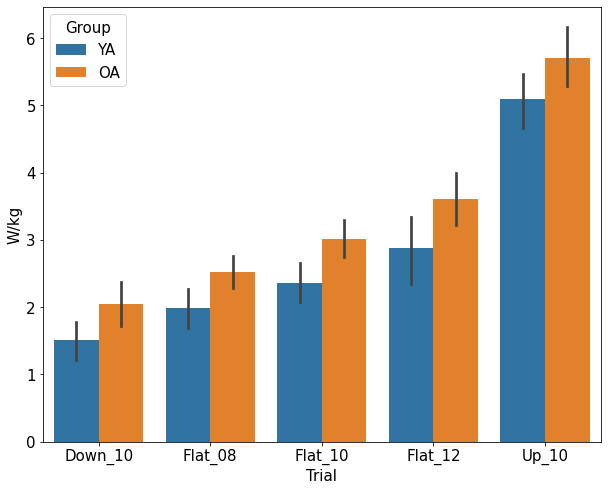

In [54]:
Obj = pd.read_csv('ObjMetCost.csv')
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 8))
sb.barplot(data=Obj, x='Trial', y='MetCost', hue='Group')
plt.ylabel('W/kg')

In [ ]:
plt.figure(figsize=(10, 6))
sb.histplot(data=DF, x='MetCost', hue='Cond', element='poly')
plt.title('Range of Walking Metabolic Costs Across Conditions')
plt.xlabel('Metabolic Cost (W/kg)')

# Visualize Keypoint Data


In [59]:
# label vars
r = 1
TRC_1 = DF.iloc[r,4:4204]
TRC_2 = DF.iloc[r,4204:8404]
S = str(DF['Subj'].iloc[r])
C = str(DF['Cond'].iloc[r])
MC = str(round(DF['MetCost'].iloc[r], 2))
name_str = (S, C, MC)
gif_name = '_'.join(name_str)

# generate settings for column naming
N = 42
A = np.array(TRC_1).reshape((100, N))
x = list(range(0, N, 3))
y = list(range(1, N, 3))
z = list(range(2, N, 3))
Std = np.array(TRC_2).reshape((100, N))
TrimKeypoints = ['RShoulder.X', 'RShoulder.Y', 'RShoulder.Z',
      'RElbow.X', 'RElbow.Y', 'RElbow.Z', 'RWrist.X', 'RWrist.Y', 'RWrist.Z',
      'LShoulder.X', 'LShoulder.Y', 'LShoulder.Z', 'LElbow.X', 'LElbow.Y', 'LElbow.Z', 
      'LWrist.X', 'LWrist.Y', 'LWrist.Z', 'RHip.X', 'RHip.Y', 'RHip.Z', 
      'RKnee.X', 'RKnee.Y', 'RKnee.Z', 'RAnkle.X', 'RAnkle.Y', 'RAnkle.Z', 
      'LHip.X', 'LHip.Y', 'LHip.Z', 'LKnee.X', 'LKnee.Y', 'LKnee.Z', 
      'LAnkle.X', 'LAnkle.Y', 'LAnkle.Z', 'RToe.X', 'RToe.Y', 'RToe.Z', 
      'LToe.X', 'LToe.Y', 'LToe.Z']
MkrNames = []
for i in z:  
  MkrNames.append(TrimKeypoints[i][0:-2])
MkrNames

['RShoulder',
 'RElbow',
 'RWrist',
 'LShoulder',
 'LElbow',
 'LWrist',
 'RHip',
 'RKnee',
 'RAnkle',
 'LHip',
 'LKnee',
 'LAnkle',
 'RToe',
 'LToe']

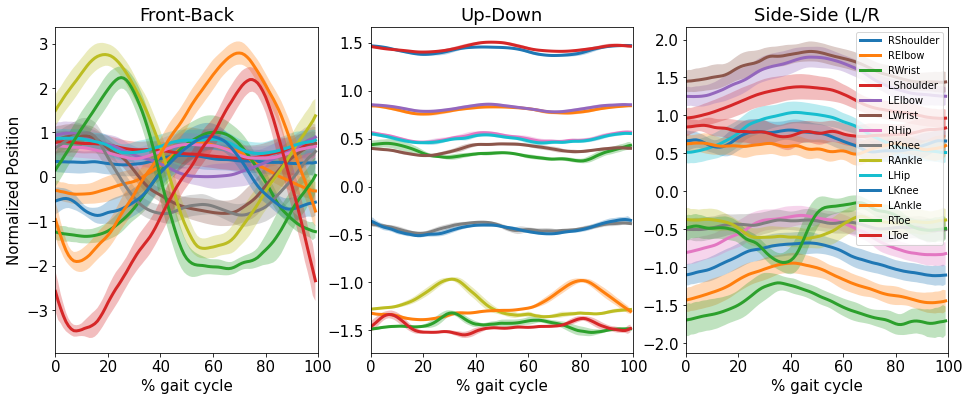

In [62]:
# plot average keypoint positions for each
A1 = 0.3
LW = 3
X = np.arange(100)

plt.figure(figsize=(16,6))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)
for i in range(len(x)):
  ax1.fill_between(X.tolist(), np.add(A[:,x[i]], Std[:,x[i]]).tolist(), np.subtract(A[:,x[i]], Std[:,x[i]]).tolist(), alpha=A1, label='_hidden')
  ax1.plot(X, A[:, x[i]], lw=LW)
  ax2.fill_between(X.tolist(), np.add(A[:,y[i]], Std[:,y[i]]).tolist(), np.subtract(A[:,y[i]], Std[:,y[i]]).tolist(), alpha=A1, label='_hidden')
  ax2.plot(A[:, y[i]], lw=LW)
  ax3.fill_between(X.tolist(), np.add(A[:,z[i]], Std[:,z[i]]).tolist(), np.subtract(A[:,z[i]], Std[:,z[i]]).tolist(), alpha=A1, label='_hidden')
  ax3.plot(A[:, z[i]], lw=LW, label=MkrNames[i])

ax1.set_ylabel('Normalized Position')
ax1.set_xlabel('% gait cycle')
ax2.set_xlabel('% gait cycle')
ax3.set_xlabel('% gait cycle')
ax1.set_xlim((0, 100))
ax2.set_xlim((0, 100))
ax3.set_xlim((0, 100))
ax1.set_title('Front-Back')
ax2.set_title('Up-Down')
ax3.set_title('Side-Side (L/R')

ax3.legend(fontsize=10, loc='upper right')
plt.savefig('Figs/KeypointPositions.png')
plt.savefig('Figs/KeypointPositions.pdf')

Plotting s004_Flat_08_4_2_2.86


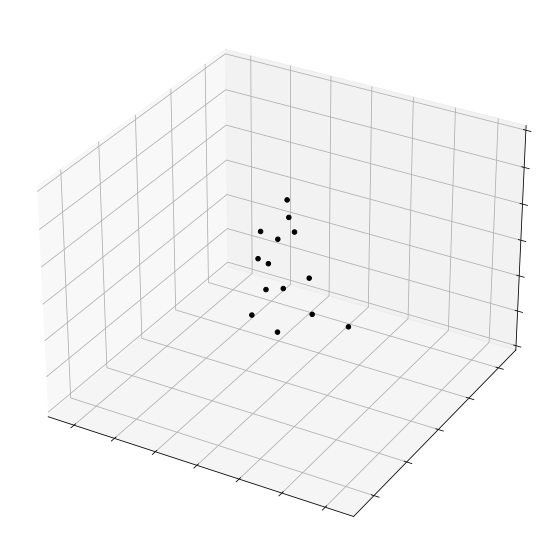

In [72]:
Viz = 1
if Viz == 1:
  i = 20
  plt.close('all')
  my_images = []
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(projection='3d')

  TRC = DF.iloc[i,4:]
  S = str(DF['Subj'].iloc[i])
  C = str(DF['Cond'].iloc[i])
  E = str(DF['Bin'].iloc[i])
  MC = str(round(DF['MetCost'].iloc[i], 2))
  name_str = (S, C, E, MC)
  gif_name = '_'.join(name_str)
  print('Plotting ' + gif_name)

  d = 42
  Avg = DF.iloc[r,4:4204]
  Std = DF.iloc[r,4204:8404]
  A = np.reshape(Avg.to_list(), (100, d))
  x = list(range(0, int(d), 3))
  y = list(range(1, int(d), 3))
  z = list(range(2, int(d), 3))
  ax.set_title(gif_name)

  for t in range(100):
    plt.cla()
    ax.scatter(-A[t,x], A[t,z], A[t,y], color='k', marker='o', alpha=1)
    ax.set_xlim3d([-7,7])
    ax.set_ylim3d([-5,5])
    ax.set_zlim3d([-3,3])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    my_images.append(image)

  # save as gif    
  gif_path = 'GIFs/' + gif_name + '.gif'
  imageio.mimsave(gif_path, my_images, fps=50)
  # optimize(gif_path)

In [120]:
y

[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41]

# Augment data
Flip medial-lateral axis to make a symmetrical copy

In [154]:
df = DF.copy() # make a copy of the input DF to not change that array
TRC = df.iloc[0,4:].to_numpy()
print(TRC)
S = np.shape(TRC)
newTRC = TRC.reshape((100, 84))

# for i in range(S[0]):
#   TRC[i,:].reshape()
nS = newTRC.shape
y = list(range(2, 84, 3)) # get y indicies to flip
newTRC[:,y] = -newTRC[:,y] 
df.iloc[0,4:] = newTRC.reshape(S, order='A')

[0.2673667985342938 1.3838528619015773 -0.7843163104088079 ...
 0.2060623787717218 0.0093645877814036 0.1417543466209918]


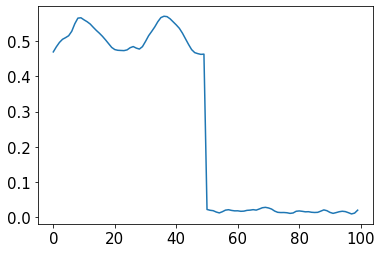

In [155]:
# newTRC.shape
plt.plot(newTRC[:,19])
# plt.plot(df.iloc[0,4:104])
# S

In [144]:
newTRC.shape

(100, 84)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300


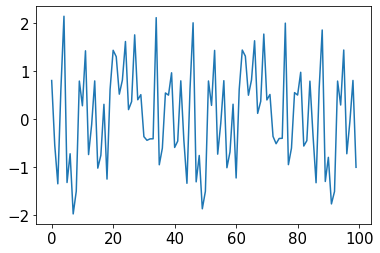

In [113]:
j = 0
# M = TRC[j,:].reshape((100, 84), order='A')
M = np.zeros((100, 84))
for i,x in enumerate(TRC[j,:]):
  p = i / 100
  if int(p) == p:
    print(i)
    M[:,int(p)] = TRC[j,i:i+100]
#   M

plt.plot(M[:,2])

In [73]:
def FlipY(DF): # define function to augment data by flipping Y axis
  df = DF.copy() # make a copy of the input DF to not change that array
  TRC = df.iloc[:,4:].to_numpy()
  S = np.shape(TRC)
  newTRC = TRC.reshape((100, 42, -1))
  nS = newTRC.shape
  y = list(range(2, 42, 3)) # get y indicies to flip
  newTRC[:,:,y] = -newTRC[:,:,y] 
  df.iloc[:,4:] = newTRC.reshape(S)
  return df


def PlotKeypoints(DF, Subj, Cond, Bin, ax): # plotting function to check augmentation

  # select a subset of the data. For example: Bin = 1, Condition = S_Norm
  SubjMatch = [i for i, x in enumerate(DF['Subj']) if Subj in x]
  CondMatch = [i for i, x in enumerate(DF['Cond']) if Cond in x]
  BinMatch = [i for i, x in enumerate(DF['Bin']) if Bin == x]
  match = set(SubjMatch) & set(BinMatch) & set(CondMatch) # get intersection of matched subjects, bins, & conditions 

  # Visualize Dataset
  if ax == 0:
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111, projection='3d')
  for i, r in enumerate(match): # loop through matches
    TRC = DF.iloc[r,4:4204]
    d = 42
    A = np.reshape(TRC.to_list(), (100, d))
    x = list(range(0, int(d), 3))
    y = list(range(1, int(d), 3))
    z = list(range(2, int(d), 3))
    MS = 6
    t = 0 # first frame
    ax.plot(A[t,x], A[t,z], A[t,y], '.k', alpha=1, markersize = MS) 
    ax.set_title(gif_name + ' Time ' + str(round(t/50, 1)) + ' s')
    ax.set_xlim3d(min(np.min(A, axis=0)), max(np.max(A, axis=0)))
    ax.set_ylim3d(min(np.min(A, axis=0)), max(np.max(A, axis=0)))
    ax.set_zlim3d(min(np.min(A, axis=0)), max(np.max(A, axis=0)))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    ax.view_init(20, 0)

Text(0.5, 0.92, 'Augmented (Flipped)')

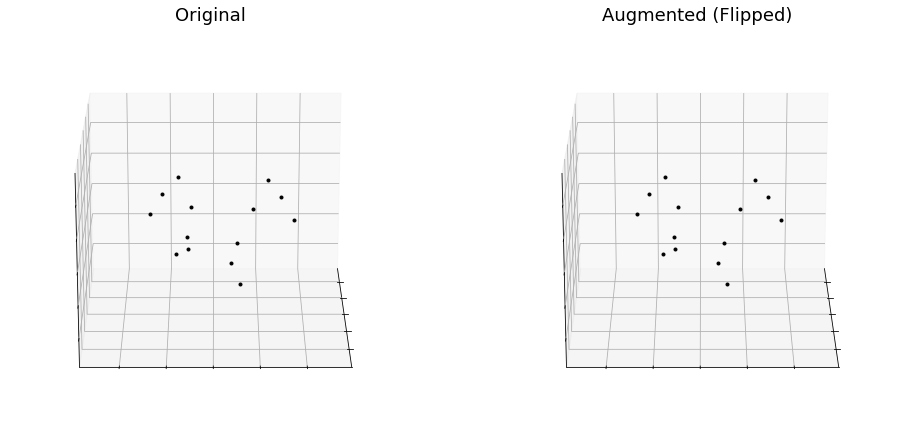

In [74]:
# Augment Dataset
FlipDF = FlipY(DF)
Aug = pd.concat([DF, FlipDF], axis=0)
Aug.dropna()

# plot augmentation
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot(121, projection='3d')
ax2 = plt.subplot(122, projection='3d')

PlotKeypoints(DF, 's003', 'Flat_12', 1, ax1)
PlotKeypoints(FlipDF, 's003', 'Flat_12', 1, ax2)

ax1.set_title('Original')
ax2.set_title('Augmented (Flipped)')

# Machine Learning Analysis

In [ ]:
# get column names
ColList = list(DF.columns[4:4204])
ColNames = np.array(ColList).reshape((100,42))
ColNames = ColNames[0,:].tolist()
ColNameAvg = [t + '_Avg' for t in ColNames]
ColNameStd = [t + '_Std' for t in ColNames]

# define train-test split
SubjInds = np.unique(DF.iloc[:, 0])
train_index = []
test_index = []
train_sub = SubjInds[0:8].tolist() + SubjInds[10:-2].tolist()
test_sub = SubjInds[8:10].tolist() + SubjInds[-2:].tolist()
for x in train_sub:
  train_index.append(SubjInds.tolist().index(x))
for x in test_sub:
  test_index.append(SubjInds.tolist().index(x))
print(f"  Train: index={SubjInds[train_index]}")
print(f"  Test:  index={SubjInds[test_index]}")

  Train: index=['s003' 's004' 's005' 's006' 's007' 's008' 's009' 's010' 's101' 's102'
 's103' 's104' 's105' 's107' 's108']
  Test:  index=['s011' 's012' 's109' 's110']


## Basic Model


In [ ]:
# create dictionaries to save data
AvgStd = {}
AvgStd['MLP'] = {}
AvgStd['SVR'] = {}

# split into training and testing set - subject leave out
TrainInds = [i for i,x in enumerate(DF.iloc[:,0]) if x in SubjInds[train_index]]
TestInds = [i for i,x in enumerate(DF.iloc[:,0]) if x in SubjInds[test_index]]
X_train = DF.iloc[TrainInds,4:]
X_test = DF.iloc[TestInds,4:]
y_train = DF.iloc[TrainInds,3]
y_test = DF.iloc[TestInds,3]

# SVR
svr = SVR().fit(X_train, y_train)
# AvgStd['SVR'].append(svr.score(X_test, y_test))
AvgStd['SVR']['R2'] = svr.score(X_test, y_test)
AvgStd['SVR']['Err'] = np.mean(abs(y_test - svr.predict(X_test)))
AvgStd['SVR']['Per Err'] = np.mean(np.divide(abs(y_test - svr.predict(X_test)), y_test))
joblib.dump(svr, 'Models/SVR.mdl', compress=0) # save model

# multilayer perceptron
mlp = MLPRegressor().fit(X_train, y_train)
AvgStd['MLP']['R2'] = mlp.score(X_test, y_test)
AvgStd['MLP']['Err'] = np.mean(abs(y_test - mlp.predict(X_test)))
AvgStd['MLP']['Per Err'] = np.mean(np.divide(abs(y_test - mlp.predict(X_test)), y_test))
joblib.dump(mlp, 'Models/MLP.mdl', compress=0) # save model

print(AvgStd)

['Models/MLP.mdl']

Text(0, 0.5, 'Estimated')

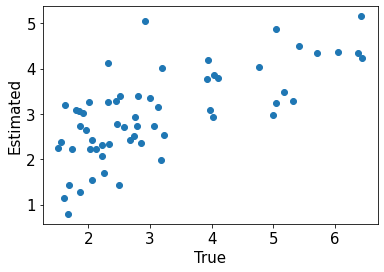

In [ ]:
plt.scatter(y_test, mlp.predict(X_test))
plt.xlabel('True')
plt.ylabel('Estimated')

## Augmented Machine Learning


In [ ]:
# create dictionaries to save data
AugML = {}
AugML['MLP'] = {}
AugML['SVR'] = {}

# split into training and testing set - subject leave out
TrainInds = [i for i,x in enumerate(Aug.iloc[:,0]) if x in SubjInds[train_index]]
TestInds = [i for i,x in enumerate(Aug.iloc[:,0]) if x in SubjInds[test_index]]
X_train = Aug.iloc[TrainInds,4:]
X_test = Aug.iloc[TestInds,4:]
y_train = Aug.iloc[TrainInds,3]
y_test = Aug.iloc[TestInds,3]

# SVR
svr = SVR().fit(X_train, y_train)
AugML['SVR']['R2'] = svr.score(X_test, y_test)
AugML['SVR']['Err'] = np.mean(abs(y_test - svr.predict(X_test)))
AugML['SVR']['Per Err'] = np.mean(np.divide(abs(y_test - svr.predict(X_test)), y_test))
joblib.dump(svr, 'Models/SVR_Aug.mdl', compress=0) # save model

# multilayer perceptron
mlp = MLPRegressor().fit(X_train, y_train)
AugML['MLP']['R2'] = mlp.score(X_test, y_test)
AugML['MLP']['Err'] = np.mean(abs(y_test - mlp.predict(X_test)))
AugML['MLP']['Per Err'] = np.mean(np.divide(abs(y_test - mlp.predict(X_test)), y_test))
joblib.dump(mlp, 'Models/MLP_Aug.mdl', compress=0) # save model

print(AugML)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'MLP': {'R2': -3.738909709419479, 'Err': 2.5817214984962336, 'Per Err': 0.7533185848468779}, 'SVR': {'R2': 0.27150087878767826, 'Err': 0.8205535151717486, 'Per Err': 0.22360785022380175}}


(0.0, 7.0)

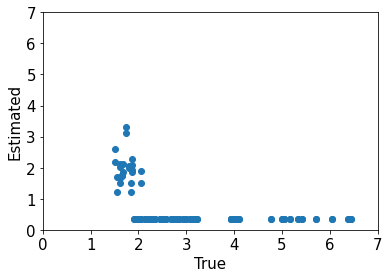

In [ ]:
plt.scatter(y_test, mlp.predict(X_test))
plt.xlabel('True')
plt.ylabel('Estimated')
plt.xlim([0, 7])
plt.ylim([0, 7])

## 2D Analysis


In [ ]:
# create dictionaries to save data
TwoD = {}
TwoD['MLP'] = {}
TwoD['SVR'] = {}

ThirdD = list(range(6, 8404, 3))
Aug2D = Aug.drop(columns = Aug.iloc[:,ThirdD].columns.to_list())
Aug2D.shape

# split into training and testing set - subject leave out
TrainInds = [i for i,x in enumerate(Aug2D.iloc[:,0]) if x in SubjInds[train_index]]
TestInds = [i for i,x in enumerate(Aug2D.iloc[:,0]) if x in SubjInds[test_index]]
X_train = Aug2D.iloc[TrainInds,4:]
X_test = Aug2D.iloc[TestInds,4:]
y_train = Aug2D.iloc[TrainInds,3]
y_test = Aug2D.iloc[TestInds,3]

# SVR
svr = SVR().fit(X_train, y_train)
# TwoD['SVR'].append(svr.score(X_test, y_test))
TwoD['SVR']['R2'] = svr.score(X_test, y_test)
TwoD['SVR']['Err'] = np.mean(abs(y_test - svr.predict(X_test)))
TwoD['SVR']['Per Err'] = np.mean(np.divide(abs(y_test - svr.predict(X_test)), y_test))
joblib.dump(svr, 'Models/SVR_Aug_2D.mdl', compress=0) # save model

# multilayer perceptron
mlp = MLPRegressor().fit(X_train, y_train)
TwoD['MLP']['R2'] = mlp.score(X_test, y_test)
TwoD['MLP']['Err'] = np.mean(abs(y_test - mlp.predict(X_test)))
TwoD['MLP']['Per Err'] = np.mean(np.divide(abs(y_test - mlp.predict(X_test)), y_test))
joblib.dump(mlp, 'Models/MLP_Aug_2D.mdl', compress=0) # save model

print(TwoD)

(0.0, 7.0)

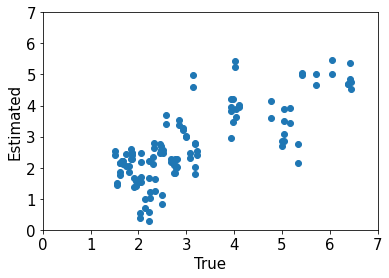

In [ ]:
plt.scatter(y_test, mlp.predict(X_test))
plt.xlabel('True')
plt.ylabel('Estimated')
plt.xlim([0, 7])
plt.ylim([0, 7])

## HR analysis


In [38]:
# load HR dataset
c = ['Subj','Cond','Bin', 'AvgHR'] # make column names for dataFrame
HRdf = pd.DataFrame(columns=c)

def splitall(path): # create function to split up file paths
    allparts = []
    while 1: 
        parts = os.path.split(path)
        if parts[0] == path: # sentinel for absolute paths
            allparts.insert(0, parts[0])
            break
        elif parts[1] == path: # sentinel for relative paths
            allparts.insert(0, parts[1])
            break
        else:
            path = parts[0]
            allparts.insert(0, parts[1])
    return allparts

# load HR from all the csv files
for root, d, files, in os.walk(DataFolder):
  for name in files: 
    if 'Pilot' in root: 
      continue
    if 'Fitbit HR' in name: 
      s = splitall(root)
      Subj = s[-1]
      os.chdir(root)
      HRdf = pd.read_csv(name)  # get HR data

In [43]:
# convert time to elapsed seconds

[i for i,x in enumerate(t) if '12:14:' in x]
    t = MetData['hh:mm:ss '].values.tolist()
    t[0] = '00:00:00'
    # create start time as datetimes
    StartTime = datetime.strptime(t[0], "%H:%M:%S")
    
    # convert to seconds & minutes
    TimeSec = []
    for i in t:
        TrlTime = datetime.strptime(i, "%H:%M:%S")
        ts = TrlTime - StartTime
        TimeSec.append(ts.total_seconds())
    TimeMin = np.divide(TimeSec, 60) # convert to minutes

TypeError: ignored

In [46]:
t = HRdf['Time'].values.tolist()
StartTime = '12:14' + ':'
Inds = [i for i,x in enumerate(t) if StartTime in x]

[441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451]

In [ ]:
t

In [ ]:
# ColNameAvg = [t + '_Avg' for t in ColNames]
# ColNameStd = [t + '_Std' for t in ColNames]
# AvgDF = pd.DataFrame(columns=[np.repeat([ColNameAvg + ColNameStd], 100)])
# MetaDF = Aug.iloc[:,:5]

# # use right toe anterior-posterior location to identify strides
# from scipy.signal import find_peaks, resample
# for x in range(len(Aug)):
#   Sub = Aug.iloc[x,5:].to_numpy().reshape((DIM, -1), order='F') # load subject data
#   Rti = ColNames.index('RTOEx') # get toe X position
#   pks, props = find_peaks(Sub[:,Rti]) # find peaks to split at those indicies
#   # plt.figure(figsize=(12,6))
#   # plt.plot(Sub[:,Rti])
#   # plt.vlines(pks, -2, 3)

#   Rsteps = np.ndarray((100, Sub.shape[1], len(pks)-1)) 
#   for s in range(len(pks)-1): # average data across steps
#     step = Sub[pks[s]:pks[s+1], :]
#     Rsteps[:,:,s] = resample(step, 100, axis=0)
#     # plt.plot(Rsteps[:,12,s])

#   SubAvg = Rsteps.mean(axis=2)
#   SubStd = Rsteps.std(axis=2)
#   AvgDF.loc[len(AvgDF),:] = np.concatenate((SubAvg.flatten(), SubStd.flatten()))


# EMG & HR Analysis

In [ ]:
# load EMG data
# LoadEMG = 1
# if LoadEMG == 1:
os.chdir('/content/drive/MyDrive/WEAV/Data')
# load csvs
EMG = pd.read_csv('WEAV_EMGdata.csv')
Meta = pd.read_csv('WEAV_Metadata.csv')

# combine and rename columns
ColNames = []
ColNames.append('Subj')
ColNames.append('Trial')
for j in [1, 2, 3, 4]:
  for i in range(100):
    ColNames.append('EMG_'+ str(j) + '_' + str(i))

# concatenate to single dataset
EMGdata = pd.concat([Meta, EMG], axis=1).dropna(how='any')
EMGdata.columns = ColNames

In [ ]:
# ColNameAvg = [t + '_Avg' for t in ColNames]
# ColNameStd = [t + '_Std' for t in ColNames]
# AvgDF = pd.DataFrame(columns=[np.repeat([ColNameAvg + ColNameStd], 100)])
# MetaDF = Aug.iloc[:,:5]

# # use right toe anterior-posterior location to identify strides
# from scipy.signal import find_peaks, resample
# for x in range(len(Aug)):
#   Sub = Aug.iloc[x,5:].to_numpy().reshape((DIM, -1), order='F') # load subject data
#   Rti = ColNames.index('RTOEx') # get toe X position
#   pks, props = find_peaks(Sub[:,Rti]) # find peaks to split at those indicies
#   # plt.figure(figsize=(12,6))
#   # plt.plot(Sub[:,Rti])
#   # plt.vlines(pks, -2, 3)

#   Rsteps = np.ndarray((100, Sub.shape[1], len(pks)-1)) 
#   for s in range(len(pks)-1): # average data across steps
#     step = Sub[pks[s]:pks[s+1], :]
#     Rsteps[:,:,s] = resample(step, 100, axis=0)
#     # plt.plot(Rsteps[:,12,s])

#   SubAvg = Rsteps.mean(axis=2)
#   SubStd = Rsteps.std(axis=2)
#   AvgDF.loc[len(AvgDF),:] = np.concatenate((SubAvg.flatten(), SubStd.flatten()))


In [ ]:
# create dictionaries to save data
Avg4 = {}
Full4 = {}
AvgStd4 = {}

# create training and testing indicies for all models
TrainInds = MetaDF[MetaDF['Subj'] <= 16].index.to_list()
TestInds = MetaDF[MetaDF['Subj'] > 16].index.to_list()

# ----------------
# FULL
Aug.reset_index()
Aug = Aug.dropna()

# split into training and testing set - subject leave out
X_train = Aug.iloc[TrainInds,5:]
X_test = Aug.iloc[TestInds,5:]
y_train = Aug.iloc[TrainInds,4]
y_test = Aug.iloc[TestInds,4]

# SVR
svr = SVR().fit(X_train, y_train)
Full4['SVR'] = svr.score(X_test, y_test)
# multilayer perceptron
mlp = MLPRegressor()
mlp.fit(X_train, y_train)
Full4['MLP'] = mlp.score(X_test, y_test)

# ------------------
# AUG AVERAGE & STD
AugAvgStd = pd.concat([MetaDF.reset_index(), AvgDF], axis=1, ignore_index=True)
AugAvgStd = AugAvgStd.dropna()

# split into training and testing set - subject leave out
X_train = AugAvgStd.iloc[TrainInds,5:]
X_test = AugAvgStd.iloc[TestInds,5:]
y_train = AugAvgStd.iloc[TrainInds,4]
y_test = AugAvgStd.iloc[TestInds,4]

# SVR
svr = SVR().fit(X_train, y_train)
AvgStd4['SVR'] = svr.score(X_test, y_test)
# multilayer perceptron
mlp = MLPRegressor()
mlp.fit(X_train, y_train)
AvgStd4['MLP'] = mlp.score(X_test, y_test)

# ----------------
# AUG AVERAGE ONLY
AugAvg = pd.concat([MetaDF.reset_index(), AvgDF.iloc[:,0:4200]], axis=1, ignore_index=True)
AugAvg = AugAvg.dropna()

# split into training and testing set - subject leave out
X_train = AugAvg.iloc[TrainInds,5:]
X_test = AugAvg.iloc[TestInds,5:]
y_train = AugAvg.iloc[TrainInds,4]
y_test = AugAvg.iloc[TestInds,4]

# SVR
svr = SVR().fit(X_train, y_train)
Avg4['SVR'] = svr.score(X_test, y_test)
# multilayer perceptron
mlp = MLPRegressor()
mlp.fit(X_train, y_train)
Avg4['MLP'] = mlp.score(X_test, y_test)

In [ ]:
# plot results
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 15})
labels = Avg4.keys()
width = 0.12
x = np.arange(len(labels))
plt.bar(x - width, list(AvgStd4.values()), width, label = 'Avg+Std')
plt.bar(x, list(Avg4.values()), width, label = 'Avg')
plt.bar(x + width, list(Full4.values()), width, label = 'Full')

plt.ylabel('$R^2$')
plt.ylim([0, 1])
plt.xticks(x, labels)
plt.legend(loc = 'best')
plt.title('4 Bin Results')